In [2]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ER 131] Homework 8: Model Selection and Regularization

This assignment explores methods that answer the question of how to choose which features to include in a model. In HW7 (resampling), we used cross-validation to evaluate how well different models generalize to new data, and one of the big takeaways was that using too many features can cause us to over-fit our model on the training data, and lead to a model that performs poorly on test data. In this HW, we'll look at two methods that attempt to reduce model variance by prioritizing certain model features: ridge regression, and lasso regression.

In this lab, we will be writing lots of functions. While these exercises take time and patience, you may find that the resulting functions are helpful in your final project (especially if you are working on a regression problem). 

A good reference for this HW is ISLR Ch. 6.

**Learning Objectives:**
* Implement ridge and lasso regression
* Describe differences in the output of linear, ridge, and lasso regression
* Explain when linear, ridge, and lasso regression might be the best choice for a prediction problem

### Table of Contents

1. [Project](#project)<br>
1. [The data](#data)<br>
1. [Comparing linear, ridge, and lasso regression](#models)<br>
1. [Choosing lambda](#lambda)<br>
1. [Comparing optimal models](#compare)<br>

## Section 0: Project (5pts)<a name='project'></a>
This week, conduct an EDA of a dataset that you are considering for your analysis.  It's ok if you use one of the starter data sets we provided you with, but use your own words to answer the questions.  

Do this together with your group members!

**Question 0.1** In a few sentences, explain where your data are from and how it was collected.

*YOUR ANSWER HERE*

**Question 0.2** Briefly summarize the structure, granularity, scope, temporality and faithfulness (write 1-2 sentences for each of structure, granularity, etc). Is there any aspect of this dataset that is limiting with respect to how you intend to use it, or any reason to question its validity?

*YOUR ANSWER HERE*

**Question 0.3** Specify at least one data cleaning operation that you will have to perform on this dataset.

*YOUR ANSWER HERE*

**Question 0.4** Describe what you did to assist your group this week. Also describe your understanding of what each of your teammates did this week. Please make sure to discuss with them if you are at all unsure of what your teammates did. It's ok if some people do more than others from one week to the next, but you should make sure that everyone's pulling weight over the semester.

*YOUR ANSWER HERE*

## Section 1: The Data<a name='data'></a>

We're going to be working with the Novotny et al. LUR data. You will recognize it from Week 6 lecture and Lab 8. As a refresher:

* The data includes GIS land-use characteristics from land-monitoring by the EPA and in situ NO2 measurements from satellite sensors.
* The goal of this land-use regression (LUR) is to estimate outdoor air pollution geospatially across the contiguous United States.
* The reason for the high number of data points is that the data keeps track of readings from monitors at a high resolution, up to ~30 meters.

First, let's upload the data to dataframe `df`.

In [3]:
# Run this block

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
# run this cell
df = pd.read_csv('data/BechleLUR_2006_allmodelbuildingdata.csv')
print(df.shape)
df.head(10)

(369, 135)


,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,04-013-0019-42602-1,AZ,33.483850,-112.142570,23.884706,20.986643,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,04-013-3002-42602-6,AZ,33.457930,-112.046010,25.089886,20.990096,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411

In this homework, we're going to be creating models for two sets of data: one for the full dataset, and one for just four states in the southwestern U.S. We'll be looking at how different approaches (linear regression, lasso, and ridge) perform with datasets that have more or fewer observations.

**Question 1.1 (1pt)** To get started, create a dataframe `df_southwest` that contains observations from `df` that are from the states of Arizona, California, Nevada, and Utah.

*Hint*: try slicing the df by using using `df['State']` and the `.isin` method to create a boolean list of dataframe entries that contain the states of interest.  Then pass that list into a `df.loc` command. 

In [5]:
df_southwest = ...# Your code here

In [6]:
# solution
df_southwest = df.loc[(df["State"].isin(['CA','AZ','UT','NV']))]
df_southwest

,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,04-013-0019-42602-1,AZ,33.483850,-112.142570,23.884706,20.986643,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,04-013-3002-42602-6,AZ,33.457930,-112.046010,25.089886,20.990096,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411

In [7]:
assert df_southwest.shape == (115,135)

**Question 1.2 (2pts)** As with the lab, we want to predict Observed_NO2_ppb, and we will use most (but not all) of the other columns as features.

Write a generalized function `get_Xy()`. This function will take as input a dataframe, `df`; a list of columns to drop , `cols_to_drop`; the name of the column holding the response variable, `y_col`; the proportion of the data to hold out as the test subset, `test_size`; and a random seed, `random_state`. **Standardize all of the features before splitting the data into testing and training sets.** The function should return four dataframes: X_train, X_test, y_train, and y_test. 

In [8]:
def get_Xy(df, cols_to_drop, y_col, test_size, random_state):
    """
    Objective: This function returns four dataframes containing the testing and training X and y values used in land-use regression.
    Input:
        - df: a Pandas dataframe with all of the fields in the land-use regression dataset; 
        - cols_to_drop: a list of the names (strings) of the columns to drop from df in order to obtain the feature variables.
        - y_col: a column name (as a string) of df that represents the response variable
        - test_size: a float between 0 and 1 indicating the fraction of the data to include in the test split
        - random_state, an integer: used to define the random state
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    # Replace the ellipses with your code
    X = df.drop(colums = ...) # The X dataframe should be a subset of df; make sure to drop the columns in the cols_to_drop list
    y = df[[...]] # The column of df containing the response variable.  
    
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(...) 
    X_stnd = scaler.transform(...)
    
    X_train, X_test, y_train, y_test = train_test_split(...)
    
    return X_train, X_test, y_train, y_test

In [9]:
# solution
def get_Xy(df, cols_to_drop, y_col, test_size, random_state):
    """
    Objective: This function returns four dataframes containing the testing and training X and y values used in land-use regression.
    Input:
        - df: a Pandas dataframe with all of the fields in the land-use regression dataset; 
        - cols_to_drop: a list of the names (strings) of the columns to drop from df in order to obtain the feature variables.
        - y_col: a column name (as a string) of df that represents the response variable
        - test_size: a float between 0 and 1 indicating the fraction of the data to include in the test split
        - random_state, an integer: used to define the random state
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    # YOUR CODE HERE
    # set your X and y
    X = df.drop(columns = cols_to_drop)
    y = df[[y_col]]
    
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(X) 
    X_stnd = scaler.transform(X)
    
    # Split your data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size=test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test

**Question 1.3a (1pt)** Call your `get_Xy` function on `df`. Save the resulting dataframes to `X_all_train, X_all_test, y_all_train, y_all_test`.

For your features, use all of the columns of `df` **except for the following:**
* "Monitor_ID", "State", "Latitude", "Longitude", "Observed_NO2_ppb", "Predicted_NO2_ppb"
* All columns that contain the string `total` (there are 30 of them in `df`). 

Write your function to hold 20% of the data as test data, with a `random_state` of 2022 as input.  This is important!  The assert functions won't work if you don't use that random state.  

In [10]:
# run this cell
total_cols = [column for column in df.columns if 'total' in column]  # Keep this line as-is.  It drops all the "total" columns

In [11]:
# YOUR CODE IN THIS CELL. 
X_all_train, X_all_test, y_all_train, y_all_test = get_Xy(...)

TypeError: get_Xy() missing 4 required positional arguments: 'cols_to_drop', 'y_col', 'test_size', and 'random_state'

In [12]:
# SOLUTION
total_cols = [column for column in df.columns if 'total' in column]
X_all_train, X_all_test, y_all_train, y_all_test = get_Xy(df=df, 
                                                           cols_to_drop=["Monitor_ID", "State", "Latitude", "Longitude", "Observed_NO2_ppb", "Predicted_NO2_ppb"] + total_cols,
                                                           y_col = 'Observed_NO2_ppb',
                                                           test_size = 0.2,
                                                           random_state=2022
                                                          ) # get X and y train and test dataframes for full dataset

**Question 1.3b (1pt)** Repeat Question 1.3, but this time call `get_Xy` on `df_southwest`. Save the resulting dataframes as `X_sw_train, X_sw_test, y_sw_train, y_sw_test`. Drop the same set of columns, hold 20% of the data for the test split, and set your random seed to be 2022. 

In [13]:
X_sw_train, X_sw_test, y_sw_train, y_sw_test = get_Xy(...)

TypeError: get_Xy() missing 4 required positional arguments: 'cols_to_drop', 'y_col', 'test_size', and 'random_state'

In [14]:
# SOLUTION
X_sw_train, X_sw_test, y_sw_train, y_sw_test = get_Xy(df=df_southwest,
                                                      cols_to_drop=["Monitor_ID", "State", "Latitude", "Longitude", "Observed_NO2_ppb", "Predicted_NO2_ppb"] + total_cols,
                                                      y_col = 'Observed_NO2_ppb',
                                                      test_size = 0.2,
                                                      random_state=2022) # get X and y train and test dataframes for CA data

In [15]:
# check dimensions of output dataframes
assert X_sw_train.shape[0] == y_sw_train.shape[0] 
assert X_all_test.shape[0] == y_all_test.shape[0] == 74
assert X_sw_test.shape[1] == X_all_test.shape[1] == 99

In [16]:
# check for standardization
assert all(-1.4 < X_all_train[:,0]) & all(X_all_train[:,0] < 4.7)
assert all(0 < y_sw_test['Observed_NO2_ppb']) & all(y_sw_test['Observed_NO2_ppb'] < 31)

## Section 2: Comparing linear, ridge, and lasso regression<a name='models'></a>

Our feature matrix has a very high number of features in it (99 to be exact, and that's after we dropped 30 of them!). It would be a big hassle to determine the importance of each independent variable. So how should we go about indentifying which features to include in our model?

As a recap from Lab 8 and from lecture, for OLS regression, a model with two features would take a form that looks something like this:

$$\Large \hat{y} = \hat{\theta_1} x_{1i} + \hat{\theta_2} x_{2i}$$

However, when we have a large number of features (the number of features $p$ approaches the number of observations), OLS can result in high variance, leading to overfit. How would we fix this problem?

Enter **regularization.** We will begin with **ridge regression ($L^2$ regularization)**. This loss function finds the values of $\theta$ that minimize mean squared error plus a **regularization** or **penalty** term. Visually...

$$ \large \hat{\theta} = \arg \min_\theta \frac{1}{n} \sum_{i=1}^n \textbf{Loss}\left(y_i, \hat{y_i}\right) + \lambda {R_{L^2}}(\theta) $$

where $\large R_{L^2}(\theta) = \sum_{k=1}^p (\theta_k)^2$ and $p$ is the number of features.

In the case of Lasso regression, we would uses the penalty term $\large R_{L^1}(\theta) = \sum_{k=1}^p \Big|\theta_k\Big|$.

In both ridge and lasso regression, $\lambda$ is a hyperparameter that we can tune to balance the bias-variance tradeoff. The higher the value of $\large \lambda$, the more a model is penalized for including additional features. Essentially, we are decreasing variance, and increasing bias with our higher $\lambda$ value, and vice versa for a smaller $\lambda$ value.

**For the purposes of `sklearn`, the lambda value will be passed in as an argument `alpha`, where $$\alpha = \lambda$$**

What value of $\lambda$ would be lead to the right-sized penalty term? We need to check a few answers to find a good option for this term. What is a technique that we know that can will check for the "best fit" across different hyperparameter instantiations? You guessed it: **cross-validation**! We'll be doing cross validation in the next section. For now, let's see how our models perform on a random train-validation split.

**Question 2.1 (2pts)** In this homework we're going to compare the results of three models: a simple linear regression, ridge regression, and lasso regression. As we know from Lab 8, `scikit-learn` has very generalizable syntax when it comes to using different models: regardless of which type of regression you are performing, you instantiate a model and save that instance of the model to a variable (eg. `lm = LinearRegression()`), then use `.fit()` to fit that model to the training data and `.predict()` to output predictions for test (or validation) data.

In this question, we're going to complete a function `fit_model()` that automates the process of initializing a model, fitting that model, and getting predictions. The function should return two sets of values: 
1. The model coefficients (a list of float values); and 
2. The test (or validation) mean squared error of the model (a single float value).

We've gotten you started with some skeleton code. It may be helpful to test out each part of the function separately, and then put it all together. It also may be helpful to look back at Lab 8 to see how we built a similar function.

*Hint:* We're fitting one of three potential models here: LinearRegression(), Ridge(), or Lasso(). While Ridge() and Lasso() take in an alpha argument, LinearRegression() does not! That means your code has to check which type of model you'll be fitting before initializing that model and (if Lasso or Ridge) passing an alpha argument to it.

*Note:* When getting the coefficients of a model using `.coef_`, sometimes scikit-learn returns a 1D array and sometimes it returns a nested array (i.e. with double brackets). To make sure that the dimensions of the coefficients that you output using this function are always the same, we include a line of code suggesting the use of the [numpy .flatten() method](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html). If you prefer, you can remove this line and take your own approach to reshaping the output of `.coef_`.

In [17]:
def fit_model(SKL_model, X_train, X_test, y_train, y_test, alpha = 1):
    """
    Objective: This function fits a model of type SKL_model to the data in the training set of X and y, and finds the MSE on the test set of X and y.
    Inputs: 
        SKL_model: the type of sklearn model with which to fit the data. Options include: LinearRegression, Ridge, or Lasso.
        X_train: the set of features used to train the model.
        y_train: the set of response variable observations used to train the model.
        X_test: the set of features used to test the model.
        y_test: the set of response variable observations used to test the model.
        alpha: the penalty parameter (also known as lambda), to be used with Ridge and Lasso models only.
    Outputs:
        mse: mean squared error
        coef: coefficients of the model  
    """    
    
    # YOUR CODE HERE
    
    # Initialize the model, differentiating between models that require and do not require the alpha parameter
    if ...:
        model = SKL_model()
    else:
        model = SKL_model(alpha = alpha)
    
    # Fit the model on the training data and get the mean squared error on the test data
    model.fit(...)
    mse = ...
    coef = model.coef_.flatten() # This line ensures your function returns a 1D array of coefficients
    
    return mse, coef

In [18]:
# solution
def fit_model(SKL_model, X_train, X_test, y_train, y_test, alpha = 1):
    """
    This function fits a model of type Model to the data in the training set of X and y, and finds the MSE on the test set of X and y.
    Inputs: 
        SKL_model: the type of sklearn model with which to fit the data. Options include: LinearRegression, Ridge, or Lasso
        X_train: the set of features used to train the model
        y_train: the set of response variable observations used to train the model
        X_test: the set of features used to test the model
        y_test: the set of response variable observations used to test the model
        alpha: the penalty parameter, to be used with Ridge and Lasso models only
    Outputs:
        mse: mean squared error
        coef: coefficient of the model
    """    
    
    # YOUR CODE HERE
    
    if SKL_model == LinearRegression:
        model = SKL_model()
    else:
        model = SKL_model(alpha = alpha)
        
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))
    coef = model.coef_.flatten()
    
    return mse, coef

In [19]:
# run this cell to confirm that fit_model() works as expected

# check the MSE of using Ridge regression on the full data - the value should be ~ 11 if your random_state was 2022 in get_Xy
assert 10 < fit_model(Ridge, X_all_train, X_all_test, y_all_train, y_all_test)[0] < 11

# make sure that the number of coefficients is equal to the number of features
assert len(fit_model(LinearRegression, X_all_train, X_all_test, y_all_train, y_all_test)[1]) == 99

# check that Lasso is reducing the coefficients as expected - i.e. by setting some coefficients to zero
assert np.count_nonzero(fit_model(Lasso, X_all_train, X_all_test, y_all_train, y_all_test)[1]) < len(fit_model(Lasso, X_all_train, X_all_test, y_all_train, y_all_test)[1])

**Question 2.2a (1pt)** Call `fit_model()` **3 times** on the training and testing data for the full dataset (i.e., your outputs to Question 1.3a): once with `SKL_model = LinearRegression`, once with `SKL_model = Ridge` and once with `SKL_model = Lasso`. For ridge and lasso, you can leave `alpha` value as its default value (1). 

Save both the MSE and the coefficient output every time you run the models. You'll end up with 3 MSE values (saved in an array called `mse_all`) and 3 sets of coefficients (saved in an array called `coef_all`). We've provided skeleton code, but you're free to take your own approach.

In [20]:
Models = [LinearRegression, Ridge, Lasso]

# initialize an array that will hold the MSE values. Each element corresponds to a model in Models 
mse_all = np.full(len(Models),np.nan)

# initialize an array that will hold coefficients. Each row is a coefficient, and each column corresponds to a different type of model in Models
coef_all = np.full((X_all_train.shape[1], len(Models)),np.nan)

for m in range(len(Models)): 
    mse_all[m], coef_all[:,m] = fit_model(...) # Replace the ellipses with your code

TypeError: fit_model() missing 4 required positional arguments: 'X_train', 'X_test', 'y_train', and 'y_test'

In [21]:
# possible solution

Models = [LinearRegression, Ridge, Lasso] # list of models

# list that will hold MSE values - each element corresponds to a model in Models
mse_all = np.full(len(Models),np.nan)

# initialize array that will hold coefficients - each column corresponds to a model in Models
coef_all = np.full((X_all_train.shape[1], len(Models)),np.nan)

for m in range(len(Models)): 
    mse_all[m], coef_all[:,m] = fit_model(Models[m],X_all_train, X_all_test, y_all_train, y_all_test) # Replace the ellipses with your code

# for Model, i in zip(Models, range(len(Models))):
#    # mse_all[i], coef_all[:,i] = fit_model(Model, X_all_train, X_all_test, y_all_train, y_all_test)

**Question 2.2b (1pt)** Repeat Question 2.2a, but this time, call `fit_model()` 3 times with the different `SKL_model`s using the training and testing data for the **df_southwest** dataset (i.e., your outputs to Question 1.3b). 

You will end up with 3 more MSE values and 3 more sets of coefficients. Save the MSEs in array named `mse_southwest` and the coefficients in an array named `coef_southwest`.  

In [22]:
# initialize a list that will hold MSE values - each element corresponds to a model in Models.  Hint: you can use np.full(...) to create an array, populate it with np.nan values.  How big should np.full be?
mse_southwest = ...

# initialize array that will hold coefficients - each column corresponds to a model in Models.  Hint: again, use np.full, but this time the array will have a different dimension.
coef_southwest = ...

# YOUR CODE HERE
for m in range(...):
    mse_southwest[m], coef_southwest[:,m] = fit_model(...)
    

TypeError: 'ellipsis' object cannot be interpreted as an integer

In [23]:
# possible solution

# list that will hold MSE values - each element corresponds to a model in Models
mse_southwest = np.full(len(Models),np.nan)

# initialize array that will hold coefficients - each column corresponds to a model in Models
coef_southwest = np.full((X_sw_train.shape[1], len(Models)),np.nan)

for m in range(len(Models)): 
    mse_southwest[m], coef_southwest[:,m] = fit_model(Models[m], X_sw_train, X_sw_test, y_sw_train, y_sw_test) # Replace the ellipses with your code

# for Model, i in zip(Models, np.arange(len(Models))):
#     mse_southwest[i], coef_southwest[:,i] = fit_model(Model, X_sw_train, X_sw_test, y_sw_train, y_sw_test)

**Question 2.3 (2 pts)** Create a plot with two subplots below. In the first subplot, plot the coefficients for ridge regression, lasso regression, and the linear model for the full dataset (i.e., `coef_all`). In the second, plot the same but for the southwestern state data (i.e., `coef_southwest`). Skeleton code is provided to construct a bar plot, but you can change this to use whatever type of plot makes the most sense to you. Feel free to use either a logarithmic scale or an untransformed y-axis. Make sure to have axis labels, titles, and legends.

TypeError: unsupported operand type(s) for +: 'int' and 'ellipsis'

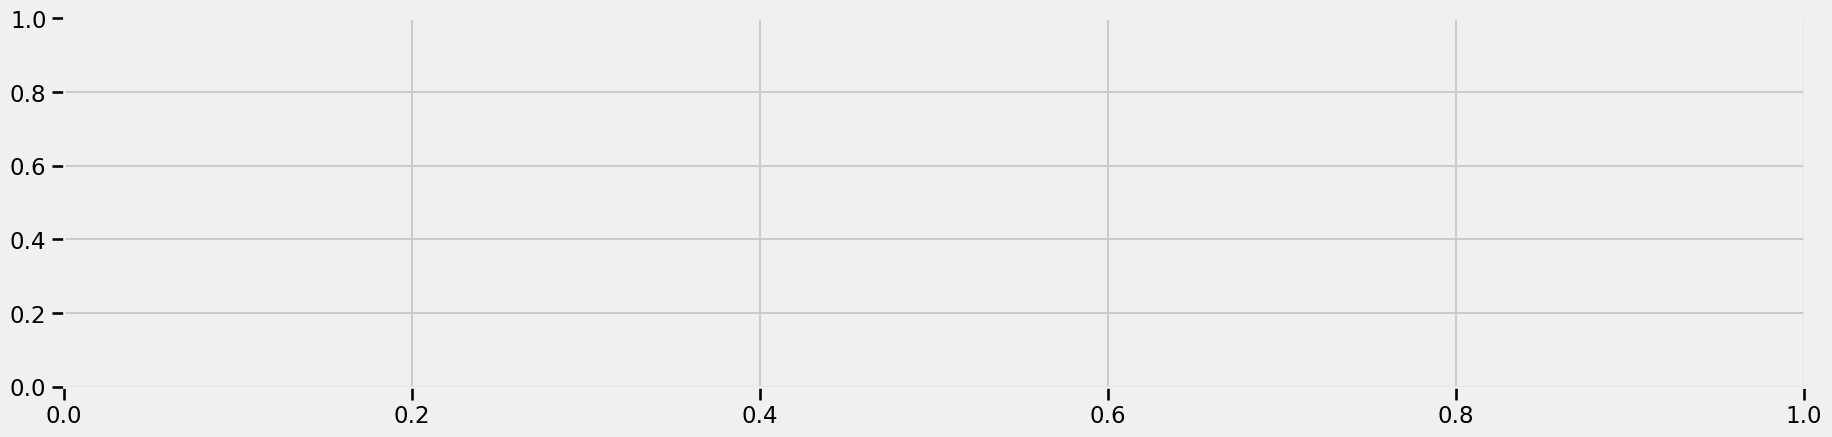

In [24]:
# Replace ellipses with your code
ind = np.arange(coef_all.shape[0]) # we want our bar chart to have one set of bars for each feature
width = 0.25  # This line and the following one set up the positions for each set of bars
pos = np.array([ind - width, ind, ind + width])
modelNames = ["Linear regression", "Ridge", "Lasso"] # you might want to use these as the labels in the your bar plots

plt.figure(figsize = (20,10))

# Plot the coefficients for Linear, Ridge, and Lasso models fit using data for all states
plt.subplot(211)
for i in np.arange(len(modelNames)): # loop through each type of model (OLS, Ridge, Lasso)
    plt.bar(x = pos[i], height = ..., width = width, label = ...)
plt.legend()
plt.xlabel(...)
plt.ylabel(...)
plt.title(...)


plt.subplot(212)
for i in np.arange(coef_southwest.shape[1]):
    plt.bar(pos[i], height = ..., width = width, label = ...)
plt.legend()
plt.xlabel(...)
plt.ylabel(...)
plt.title(...)

plt.tight_layout()
plt.show()

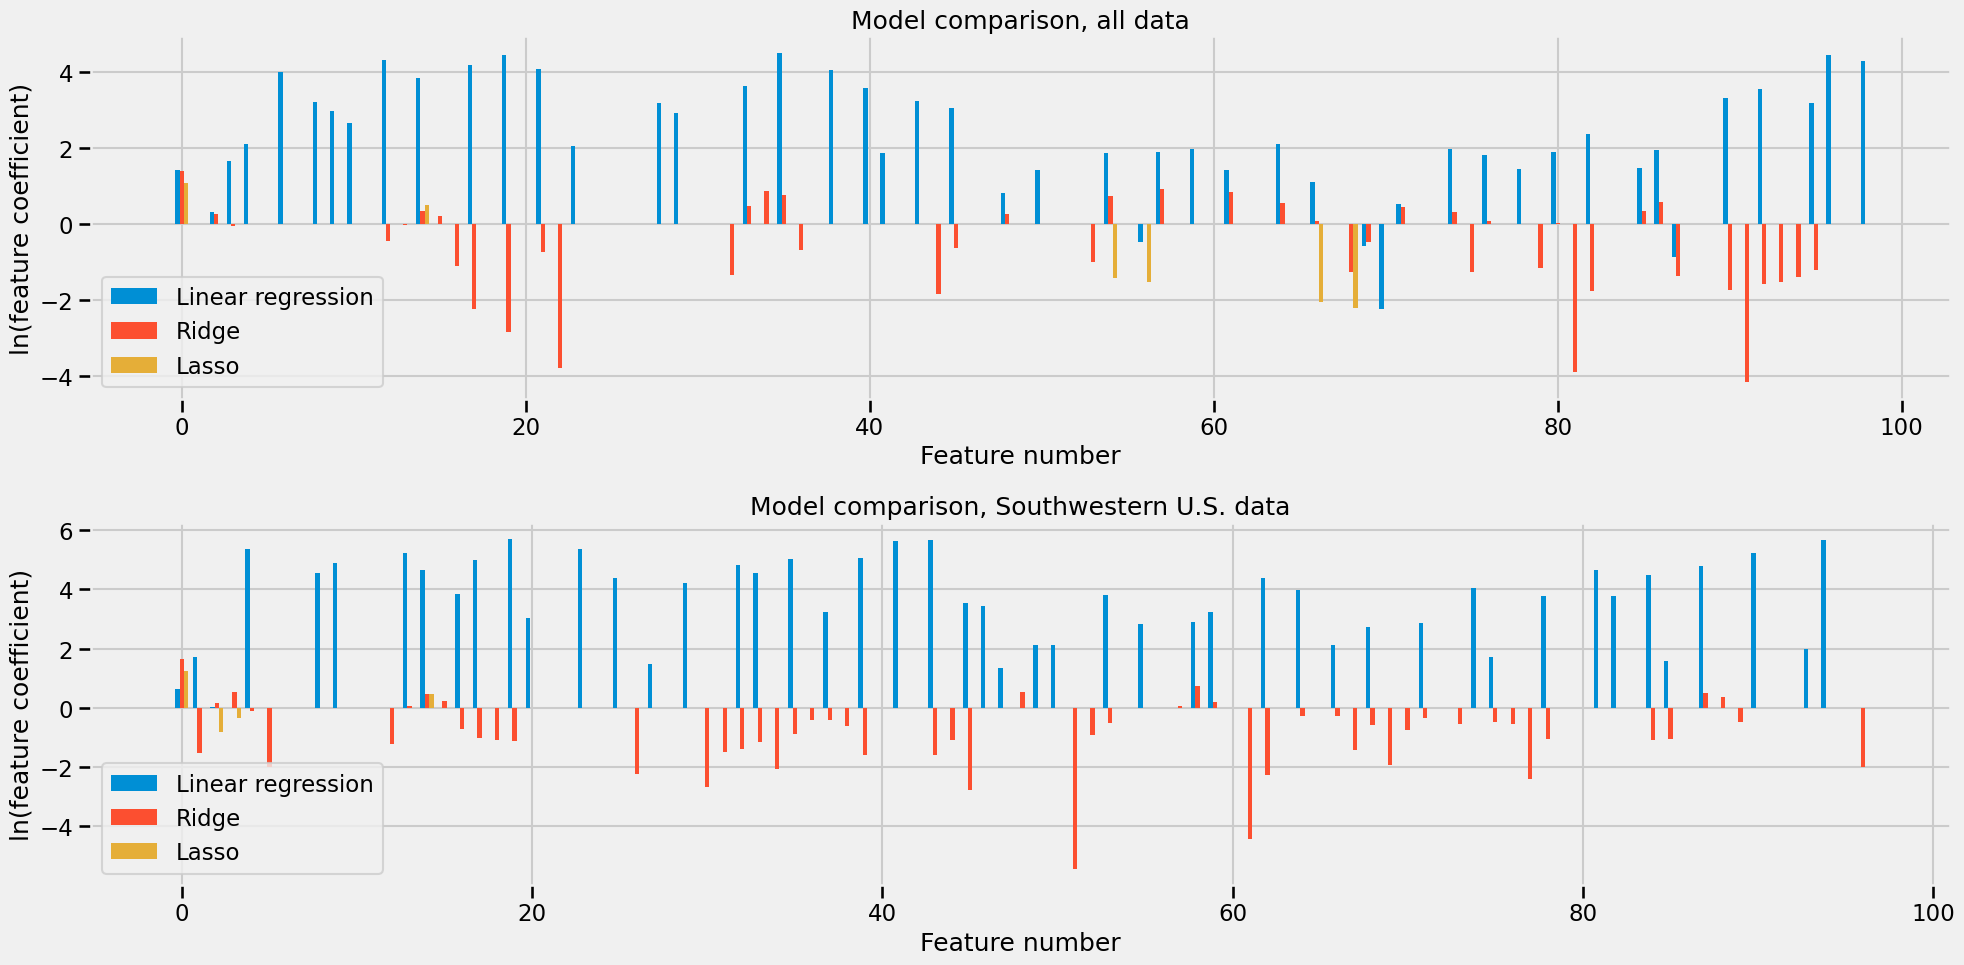

In [25]:
# possible solution
ind = np.arange(coef_all.shape[0])
width = 0.25
pos = np.array([ind - width, ind, ind + width])
modelNames = ["Linear regression", "Ridge", "Lasso"]

plt.figure(figsize = (20,10))

plt.subplot(211)
for i in np.arange(coef_all.shape[1]):
    # Try experimenting with plotting both the "raw" coefficients and the log values of the coefficients
    plt.bar(pos[i], height = np.log(coef_all[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature number")
plt.ylabel("ln(feature coefficient)")
plt.title("Model comparison, all data")


plt.subplot(212)
for i in np.arange(coef_southwest.shape[1]):
    # Try experimenting with plotting both the "raw" coefficients and the log values of the coefficients
    plt.bar(pos[i], height = np.log(coef_southwest[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature number")
plt.ylabel("ln(feature coefficient)")
plt.title("Model comparison, Southwestern U.S. data")

plt.tight_layout()
plt.show()

**Question 2.4 (3pts)** How do the coefficients from lasso, ridge, and linear regression compare to each other for the full dataset? How about for the southwestern state data? Based on your knowledge of lasso, ridge, and linear regression, can you explain why the coefficients compare in this way?

YOUR ANSWER HERE

*SOLUTION:* For both datasets, Lasso coefficients are consistently much smaller (or zero). Ridge coefficients also tend to be smaller than Linear Regression coefficients for both datasets, although on occaision for both datasets Ridge coefficients are slightly larger than Linear Regression coefficients. Ridge and Lasso will tend to be smaller than Linear Regression coefficients because they have a penalty term that penalizes adding more coefficients, or having larger magnitude coefficients - this leads to their optimal solution having smaller coefficient values. Lasso has 0-value coefficients because its penalty term allows for 0-coefficient solutions, while ridge does not.

**Question 2.5 (3pts)** Compare the 3 test MSES from the full dataset to the 3 test MSEs from the southwestern states dataset. How do the MSEs compare within model types (i.e. how does the MSE for linear regression fit on the southwestern state model compare with that of the linear regression model fit on the full model)? Can you explain how the two sets of values compare, based on what you know about bias and variance? 

Particularly, note how the MSEs change for the southwestern data data when Lasso is used vs. for all data when Lasso is used. Which set of data exhibits a larger improvement when Lasso is used? Why do you think that is?

You don't have to use a visualization for this question, although you are welcome to.

YOUR ANSWER HERE

In [26]:
# solution
print("Southwestern states: ", mse_southwest)
print("Full dataset: ", mse_all)

Southwestern states:  [315.15355176  14.71242535  14.82479471]
Full dataset:  [17.7000591  10.66874014 11.99712962]


**Possible answer**: MSEs for the southwestern data are consistently higher than they are for the full dataset, *but* lasso regression leads to a much more noticeable improvement over the linear regression for the southwestern data (MSE = 315 to MSE = 14.8 with Lasso) than it does for the full dataset (MSE = 18 to MSE = 12 for Lasso). Our southwestern models are exhibiting a lot more variance in general - this makes sense because we have a smaller set of observations, which increases our risk of overfitting the models. But the performance of the Lasso model indicates that it's especially beneficial to eliminate some features when you have a relatively small number of observations relative to the number of features.

## Section 3: Choosing lambda (aka `alpha`)<a name='lambda'></a>

To further tune our model for maximum predictive power, we'll now use cross-validation to tune our hyperparameter $\lambda$. Again, ScikitLearn models use the parameter `alpha`, which is equivalent to $\lambda$. 

In [27]:
# run this cell
from sklearn.model_selection import KFold

**Question 3.1 (2pts):** In this question, you'll complete a function `model_cv_mse()`. This function should perform k-fold cross validation on the *training* data, which is passed to the function through `X` and `y`, using the model (only `Ridge()` or `Lasso()`) specified by the input `SKL_model` for each value of alpha in the list `alphas`. It should then calculate the cross-validated MSE associated with each alpha in `alphas`, and return a list of mean squared errors.

In addition to the other inputs, include a `random_state`. Set `shuffle = True` in the `KFold` function.

This function will end up looking similar to `mse_k_fold_lr()` from HW7.

In [28]:
def model_cv_mse(SKL_model, X, y, alphas, k = 5, random_state = 8):
    """
    Objective: This function calculates the MSE resulting from k-fold CV using Lasso or Ridge regression performed on a training subset of 
    X and y for different values of alpha.
    Inputs: 
        SKL_model (sklearn model): the type of sklearn model with which to fit the data - options include Ridge, or Lasso
        X: the set of features used to fit the model
        y: the set of response variable observations
        alphas: a list of penalty parameters
        k: number of folds in k-fold cross-validation
        random_state: a random seed to use in KFold
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    mses = np.full((k,len(alphas)),np.nan) # initialize array of null values. Each row should represent one of the k folds. Each column should represent a value of alpha.
        
    kf = KFold(...) # get kfold split
    
    fold = 0
    for train_i, val_i in kf.split(X): # loop through k folds
        # get the training and validation data for each fold
        X_f_train = ...
        X_f_val = ...
        y_f_train = ...
        y_f_val = ...
        
        for i in range(len(alphas)): # loop through each value of alpha
            model = ... # initialize model and set alpha = i

            model.fit(...) # fit model
            
            y_pred = ... # get predictions on the validation data
            
            # save the MSE for this fold and alpha value
            mses[fold,i] = ...
        
        fold += 1 # move on to the next fold
    
    average_mses = ... # get the average MSE for each alpha value across all folds
    
    return average_mses

In [29]:
# solution
def model_cv_mse(SKL_model, X, y, alphas, k = 5, random_state = 8):
    """
    This function calculates the MSE resulting from k-fold CV using Lasso or Ridge regression performed on a training subset of 
    X and y for different values of alpha.
    Inputs: 
        SKL_model (sklearn model): the type of sklearn model with which to fit the data - options include Ridge, or Lasso
        X: the set of features used to fit the model
        y: the set of response variable observations
        alphas: a list of penalty parameters
        k: number of folds in k-fold cross-validation
        random_state: a random seed to use in KFold
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    mses = np.full((k,len(alphas)),np.nan)
        
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    
    fold = 0
    for train_i, val_i in kf.split(X):
        X_f_train = X[train_i]
        X_f_val = X[val_i]
        y_f_train = y.iloc[train_i]
        y_f_val = y.iloc[val_i]
        
        for i in range(len(alphas)):
            model = SKL_model(alpha = alphas[i])

            model.fit(X_f_train, y_f_train)
            
            y_pred = model.predict(X_f_val)
            
            mses[fold,i] = mean_squared_error(y_pred,y_f_val)
        
        fold += 1
    
    average_mses = np.mean(mses, axis = 0)
    
    return average_mses

In [30]:
# run this cell
alphas_test = [0.01, 0.1, 1, 10, 100, 1000, 10000]

# check dimensions of output MSEx
assert len(model_cv_mse(Ridge, X_all_train, y_all_train, alphas_test)) == len(alphas_test)

# check values of output MSE at first alpha - should be about 9.7
assert 9 < model_cv_mse(Lasso, X_all_train, y_all_train, alphas_test)[0] < 10

# check reproducibility - the function should give the same MSE for the same alphas every time it runs
assert np.array_equal(model_cv_mse(Ridge, X_all_train, y_all_train, alphas_test),
                       model_cv_mse(Ridge, X_all_train, y_all_train, alphas_test))

**Question 3.2 (2pts)** Now that we can calculate the cross-validated MSE for different values of alpha, we can visualize the relationship between alpha and cross-validated MSE. Below, complete the skeleton code to create two subplots for the dataset that includes **all** states: one that shows alpha vs. cross-validated MSE for ridge regression for the training data, and one that shows alpha vs cross-validated MSE for lasso regression for the training data. Use 10-fold CV.

It's up to you what range of alphas you want to show, but your plot should aim to roughly include the range around which the minimum MSE value appears. As a starting point, look at the output MSE values using the `test_alphas` values in the `assert` code block above, and try to decide which alphas to "zoom in" on from there - you may also decide to extend the range of alphas. It may take some trial and error.

*Hint*: You will end up with two very different ranges of alpha for lasso and ridge, and therefore different x-axis ranges. 

Make sure to add axis labels and titles.

In [31]:
alphas_ridge = ... # create an array or list of alpha values to test in Ridge regression
alphas_lasso = ... # create an array or list of alpha values to test in Lasso regression

plt.figure(figsize = (20,10))

# creating our y-axis values
y_ridge = model_cv_mse(...)
y_lasso = model_cv_mse(...)

# Plot the cross-validated MSE versus alpha for ridge
plt.subplot(121)
plt.plot(...)
plt.title(...)
plt.xlabel(...)
plt.ylabel(...)

# Plot the cross-validated MSE versus alpha for Lasso
plt.subplot(122)
plt.plot(...)
plt.title(...)
plt.xlabel(...)
plt.ylabel(...)

plt.show()

TypeError: model_cv_mse() missing 3 required positional arguments: 'X', 'y', and 'alphas'

<Figure size 2000x1000 with 0 Axes>

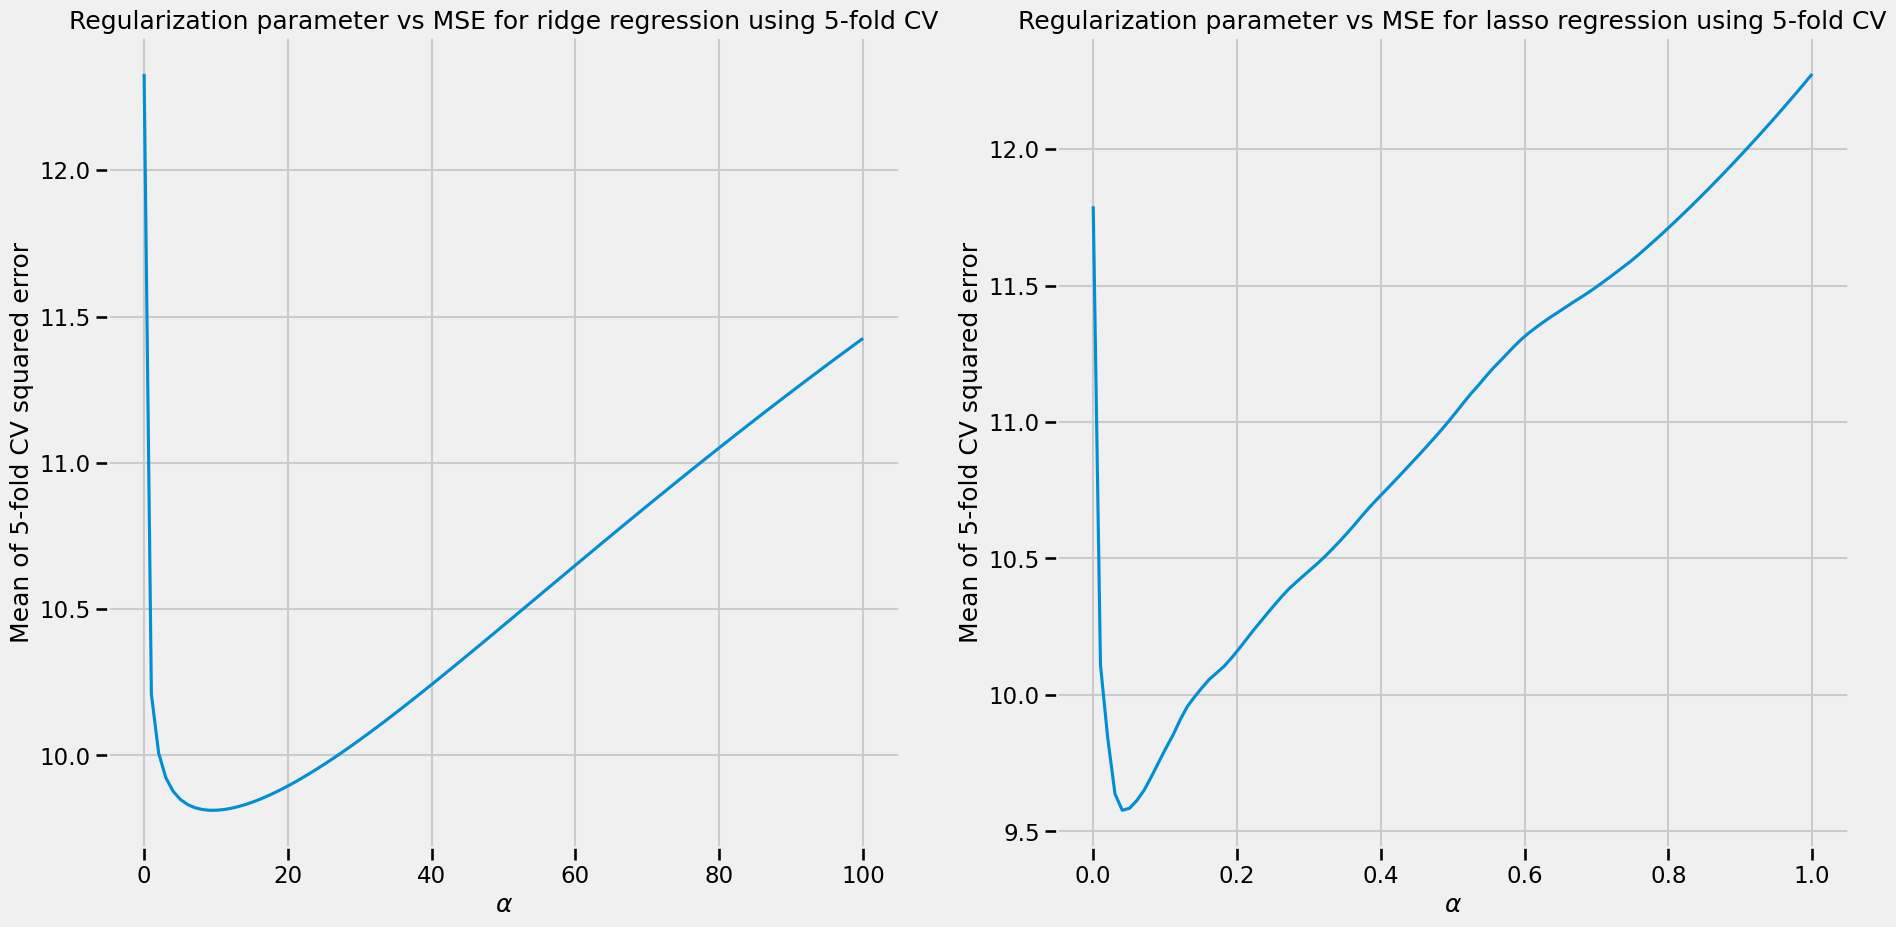

In [32]:
# possible solution
alphas_ridge = np.linspace(0.01,100, 100)
alphas_lasso = np.linspace(0, 1, 100)

plt.figure(figsize = (20,10))

plt.subplot(121)
plt.plot(alphas_ridge, model_cv_mse(Ridge, X_all_train, y_all_train, alphas_ridge, 10))
plt.title("Regularization parameter vs MSE for ridge regression using 5-fold CV")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean of 5-fold CV squared error")

plt.subplot(122)
plt.plot(alphas_lasso, model_cv_mse(Lasso, X_all_train, y_all_train, alphas_lasso, 10))
plt.title("Regularization parameter vs MSE for lasso regression using 5-fold CV")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean of 5-fold CV squared error")

plt.show()

 **Question 3.3 (1pt)** Comment on the plots above. How does the MSE change with different alphas for Ridge vs Lasso?

YOUR ANSWER HERE

*SOLUTION* Many answers accepted as long as they're relevant to the plots above; both Ridge and Lasso have pretty clear minimums, but these minimums are associated with very different values of alpha.

**Question 3.4 (2pts):** In what cases would you expect ridge regression to perform better than lasso, and vice versa? 

YOUR ANSWER HERE

*SOLUTION* Many answers are acceptable; a complete answer should discuss how adding a penalty term in lasso and ridge leads to a reduction in variance compared to OLS (i.e. they avoid overfitting); ridge performs better than lasso when the number of features in the real model is larger; lasso performs better when the number of features in the real model is smaller, and when the data is susceptible to high variance due to small sample sizes.

## Section 4: Comparing optimal models<a name='compare'></a>

In this final section, we'll compare the performance of three models: your Lasso model with optimal alpha, your Ridge model with optimal alpha, and Novotny's model.

**Question 4.1 (2pts):** Let's start by getting the optimal alpha and corresponding coefficients of the Ridge model. In this section, we'll use a new scikit-learn function, [`RidgeCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html). `RidgeCV()` is a ridge specific cross-validation function in python that takes as an input a list of alpha values and a cross-validation splitter object (which is just the output of the function `KFold(...)`).

To call `RidgeCV()`, you would want to first create a cross-validation object using `Kfold()`:

`kf = KFold(n_splits = ..., shuffle = ..., random_state = ...)`

You can then pass `kf` to `RidgeCV()`, along with a list of alpha values:

`ridgecv = RidgeCV(cv = kf, alphas = ...)`

and you can treat it essentially like any other `scikit-learn` model by calling `.fit()`:

`ridgecv.fit(X_train, y_train)`

Running the code above will, in one line, perform cross-validation, choose an ideal alpha from your list, and select the corresponding coefficients. You can then access the optimal alpha using:

`ridgecv.alpha_`

and the corresponding coefficients using:

`ridgecv.coef_`

You can also get predictions on your test data using `.predict()`:

`ridgecv.predict(X_test)`

In the cell below, we've written some skeleton code to get you started. Call `RidgeCV()` using 10-fold cross validation with a random state of 8, train the model on the training data for the full dataset (i.e. `X_all_train, y_all_train`), get predictions for the test data (i.e. `X_all_test`), and find the mean-squared-error on your cross-validated ridge model on the test data. Save the mean squared error to variable `ridge_cv_mse`.

You may also want to print the optimal alpha value to make sure it's consistent with your plot in Question 3.2.

You can use the same range of alphas that you did for plotting, or you can choose to use a smaller, larger, or more granular range.

In [33]:
from sklearn.linear_model import RidgeCV

alphas_ridge = np.linspace(0.01,100, 100)

kf = KFold(...) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = ..., alphas=...) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(...) # fit RidgeCV model on training data

ridge_alpha_opt = ... # get optimal alpha value
print("optimal alpha:", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(...) # get test predictions using RidgeCV model

ridge_cv_mse = ... # get MSE of RidgeCV model using mean_squared_error(...)
print("Test MSE with cross-validated Ridge:", ridge_cv_mse)

ValueError: The number of folds must be of Integral type. Ellipsis of type <class 'ellipsis'> was passed.

In [34]:
# solution
from sklearn.linear_model import RidgeCV

alphas_ridge = np.linspace(0.01,100, 100)

kf = KFold(n_splits = 10, shuffle = True, random_state = 8)
ridgecv = RidgeCV(cv = kf, alphas=alphas_ridge)
ridgecv.fit(X_all_train, y_all_train)

ridge_alpha_opt = ridgecv.alpha_
print("optimal alpha:", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_all_test)

ridge_cv_mse = mean_squared_error(y_pred_ridgecv, y_all_test)

print("Test MSE with cross-validated Ridge:", ridge_cv_mse)

optimal alpha: 9.1
Test MSE with cross-validated Ridge: 10.088013561205587


**Question 4.2 (2pts):** Now, let's get the optimal alpha and corresponding coefficients of the Lasso model. We'll use the function [`LassoCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). As in Question 4.1, `LassoCV()` takes as an input a list of alpha values and a cross-validation splitter object (which is just the output of the function `KFold(...)`). You would call `LassoCV()` and use it to fit a model, get predictions, and access the alpha and coefficient values in the same way you would `RidgeCV()`.

In this section, you'll want to call `LassoCV()` using 10-fold cross validation with a random state of 8, train the model on the training data for the **full** dataset (i.e. `X_all_train, y_all_train`), get predictions for the test data, and find the mean-squared-error on your cross-validated Lasso model on the test data. Save the mean squared error to variable `lasso_cv_mse`.

You may also want to print the optimal alpha value to make sure it's consistent with your plot in Question 3.2. Note that it's not unusual if LassoCV() returns an optimal alpha that's slightly different than the alpha that shows up at the minimum point in your plot in Question 3.2, due to how LassoCV() solves for coefficients. However, the alpha value should be within a reasonable range of the minimum alpha you get in Question 3.2.

Again, you can use the same range of alphas that you did for plotting, or you can choose to use a smaller, larger, or more granular range.

In [35]:
from sklearn.linear_model import LassoCV

alphas_lasso = np.linspace(0.01, .4, 50)

kf = KFold(...) # get KFold cross-validation selector object
lassocv = LassoCV(cv = ..., alphas=...) # pass CV object and list of alphas to LassoCV()
lassocv.fit(...) # fit RidgeCV model on training data

lasso_alpha_opt = ... # get optimal alpha value
print("optimal alpha:", lasso_alpha_opt)

y_pred_lassocv = ... # get test predictions using RidgeCV model

lasso_cv_mse = ... # get MSE of LassoCV model
print("Test MSE with cross-validated Lasso:", lasso_cv_mse)

ValueError: The number of folds must be of Integral type. Ellipsis of type <class 'ellipsis'> was passed.

In [36]:
# solution
from sklearn.linear_model import LassoCV

alphas_lasso = np.linspace(0.01, .4, 50)

kf = KFold(n_splits = 10, shuffle = True, random_state = 8)
lassocv = LassoCV(cv = kf, alphas=alphas_lasso)
lassocv.fit(X_all_train, y_all_train)

lasso_alpha_opt = lassocv.alpha_
print("optimal alpha:", lasso_alpha_opt)

y_pred_lassocv = lassocv.predict(X_all_test)

lasso_cv_mse = mean_squared_error(y_pred_lassocv, y_all_test)
print("Test MSE with cross-validated Lasso:", lasso_cv_mse)

optimal alpha: 0.04183673469387755
Test MSE with cross-validated Lasso: 10.090112153149686


As an aside: at this point, you might be asking yourself why we wrote the function in Question 3.1 when we can use `RidgeCV()` and `LassoCV()`. While `RidgeCV()` and `LassoCV()` are very useful for getting optimal alphas and corresponding coefficients and mean squared errors, it's harder to extract the cross-validated mean squared error for a *list* of alphas from those functions (particularly from `LassoCV()`). We wanted you to have both tools (a self-written function that calculates MSE across alphas, and scikit-learn provided functions that return the optimal alpha and coefficients) at your disposal.

Moving on!

Now, let's see how Novotny's model performed. The list `X_nov` below are the predictors that they put in their final model data set.  We use only the variables in that list to fit a multiple linear regression model on training dataset for all states. We then calculate the mean squared error for the model's prediction on the **test** data set.

In [37]:
# # Run this block. 

# keep these commented out, it's so you can see what the column names are
# X_nov = ['WRF+DOMINO',
#        'Impervious_800', 'Elevation_truncated_km', 'Major_800',
#        'Resident_100', 'Distance_to_coast_km']

X_nov = [0, 10, 2, 54, 69, 1] # These are the column numbers that correspond to the column names commented out above

X_nov_train = X_all_train[:,X_nov]
X_nov_test = X_all_test[:,X_nov]

# Fit a linear regression model on the novotny training data
novotny = LinearRegression()
novotny.fit(X_nov_train, y_all_train)

# Predict the y-values associated with the novotny test data
y_pred_nov = novotny.predict(X_nov_test)

# Find the test error
novotny_mse = mean_squared_error(y_pred_nov, y_all_test)
print("Test MSE with Novotny model:", novotny_mse)

Test MSE with Novotny model: 9.621562279219695


**Question 4.3 (3pts)** Compare the ***test MSE*** across your cross-validated Ridge and Lasso models fit with their optimal alpha values (i.e., your answers to Questions 4.1 and 4.2) with the test MSE from Novotny's linear regression model. Which of the three models performs best?  

YOUR ANSWER HERE

*SOLUTION* Answers will vary based on the alpha values used to train the Ridge and Lasso models. For the alphas we used in 4.1 and 4.2, Novotny's model performs the best with a test MSE of 10.26. Our best Ridge and Lasso models both had test MSE's slightly over 11. Still pretty good!)

----

## Submission

Congrats, you're done with Homework 8!

Before you submit, click **Kernel** --> **Restart & Clear Output**. Then, click **Cell** --> **Run All**. Then, go to the toolbar and click **File** -> **Download as** -> **.pdf** and submit the file **as both an .pdf and .ipynb file through bCourses**.

----

## Bibliography

https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/



---
Notebook developed by: Alex Nakagawa

Data Science Modules: http://data.berkeley.edu/education/modules
